In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from models.linear_attn_sw import HybridAttention
import time
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import os
os.environ['HF_TOKEN'] = 'YOUR_HF_TOKEN'
!huggingface-cli login --token $HF_TOKEN

In [3]:
base_model_name="meta-llama/Llama-3.2-1B"
hybrid_blocks_dir="hybrid_blocks"
lora_dir="llama_lora_checkpoints/best_model"

In [4]:
Base_model = AutoModelForCausalLM.from_pretrained(base_model_name)
hybrid_model = Base_model
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token

In [5]:
layer_indices = [0, 2, 4, 6, 8, 10, 12, 14]
for layer_idx in layer_indices:
    hybrid_attn = HybridAttention(Base_model.config, layer_idx=layer_idx)
    state_dict = torch.load(f"{hybrid_blocks_dir}/hybrid_layer_{layer_idx}.pt")
    hybrid_attn.load_state_dict(state_dict)
    hybrid_model.model.layers[layer_idx].self_attn = hybrid_attn

hybrid_model = hybrid_model.from_pretrained(lora_dir)

/tmp/ipykernel_12275/3532664208.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{hybrid_blocks_dir}/hybrid_layer_{layer_idx}.pt")


In [6]:
hybrid_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hybrid_model = hybrid_model.to(device)
Base_model = Base_model.to(device)

In [7]:
text = "the answer to life, the universe and everything"
input_ids = tokenizer(text, return_tensors="pt").input_ids.cuda()
outputs = Base_model.generate(input_ids, max_new_tokens=20, use_cache=False)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(decoded)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


the answer to life, the universe and everything meaning meaning meaningMean precaution Means proving meaningsMakes-mean dropselimMakes meaningsMakesmeans precautionelimMean LET


In [8]:
text = "the answer to life, the universe and everything"
input_ids = tokenizer(text, return_tensors="pt").input_ids.cuda()
outputs = hybrid_model.generate(input_ids, max_new_tokens=20, use_cache=False)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(decoded)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


the answer to life, the universe and everything is 42. The number 42 is also the answer to the question: what is the answer


In [52]:
def create_stylized_plot(results_df, metric_col, ylabel, title, filename):
    plt.figure(figsize=(12, 7))
    
    # Create the plot with seaborn
    sns.lineplot(data=results_df, x='seq_length', y=f'hybrid_{metric_col}', 
                marker='o', label='Hybrid Model', color='#FF9999')
    sns.lineplot(data=results_df, x='seq_length', y=f'base_no_cache_{metric_col}', 
                marker='s', label='Base Model (no cache)', color='#66B2FF')
    
    # Customize the plot
    plt.xscale('log', base=2)
    #plt.yscale('log', base=2)
    
    # Customize grid
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # Customize labels and title
    plt.xlabel('Sequence Length', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14, pad=20)
    
    # Customize legend
    plt.legend(frameon=True, framealpha=0.9, fontsize=10)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save plot
    plt.savefig(filename)
    plt.show()
    #plt.close()

## Measure token/sec

In [25]:
def measure_throughput(model, input_ids, use_cache=False, num_runs=3, new_tokens=20):
    """Measure tokens/sec for generation (only counting generated tokens)"""
    torch.cuda.synchronize()
    start_times = []
    end_times = []
    
    # Warmup run
    _ = model.generate(input_ids, max_new_tokens=new_tokens, use_cache=use_cache)
    
    # Actual timing runs
    for _ in range(num_runs):
        torch.cuda.synchronize()
        start = time.perf_counter()
        
        _ = model.generate(input_ids, max_new_tokens=new_tokens, use_cache=use_cache)
        
        torch.cuda.synchronize()
        end = time.perf_counter()
        
        start_times.append(start)
        end_times.append(end)
    
    # Calculate tokens per second
    # Only count the newly generated tokens, not input length
    total_generated_tokens = new_tokens * num_runs
    total_time = sum([end - start for end, start in zip(end_times, start_times)])
    return total_generated_tokens / total_time

In [34]:
results = {
    'seq_length': [],
    'hybrid_tokens_per_sec': [],
    'base_no_cache_tokens_per_sec': [],
}

In [35]:
seq_lengths = [2**i for i in range(17)]

In [36]:
print("\nRunning benchmarks...")
for seq_len in tqdm(seq_lengths):
    # Create input of required length
    input_text = "A" * seq_len
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    
    # Skip if sequence is too long for model
    if input_ids.shape[1] > Base_model.config.max_position_embeddings:
        break
        
    with torch.no_grad():
        # Test hybrid model (always use_cache=False as per your training)
        hybrid_throughput = measure_throughput(hybrid_model, input_ids, use_cache=False)
        
        # Test base model without cache
        base_no_cache_throughput = measure_throughput(
            Base_model, input_ids, use_cache=False
        )
        
        # Test base model with cache
        # base_with_cache_throughput = measure_throughput(
        #     base_model, input_ids, use_cache=True
        # )
    
    # Store results
    results['seq_length'].append(seq_len)
    results['hybrid_tokens_per_sec'].append(hybrid_throughput)
    results['base_no_cache_tokens_per_sec'].append(base_no_cache_throughput)
    # results['base_with_cache_tokens_per_sec'].append(base_with_cache_throughput)
    
    # Print current results
    print(f"\nSequence length: {seq_len}")
    print(f"Hybrid model: {hybrid_throughput:.2f} tokens/sec")
    print(f"Base model (no cache): {base_no_cache_throughput:.2f} tokens/sec")
    # print(f"Base model (with cache): {base_with_cache_throughput:.2f} tokens/sec")


Running benchmarks...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 1
Hybrid model: 52.66 tokens/sec
Base model (no cache): 57.80 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 2
Hybrid model: 80.74 tokens/sec
Base model (no cache): 69.61 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 4
Hybrid model: 79.69 tokens/sec
Base model (no cache): 69.76 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 8
Hybrid model: 80.57 tokens/sec
Base model (no cache): 69.70 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 16
Hybrid model: 80.37 tokens/sec
Base model (no cache): 69.56 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 32
Hybrid model: 79.87 tokens/sec
Base model (no cache): 69.34 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 64
Hybrid model: 80.46 tokens/sec
Base model (no cache): 68.87 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 128
Hybrid model: 80.52 tokens/sec
Base model (no cache): 67.97 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 256
Hybrid model: 78.67 tokens/sec
Base model (no cache): 65.62 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 512
Hybrid model: 68.09 tokens/sec
Base model (no cache): 58.65 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 1024
Hybrid model: 51.38 tokens/sec
Base model (no cache): 42.91 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 2048
Hybrid model: 34.63 tokens/sec
Base model (no cache): 25.72 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 4096
Hybrid model: 20.30 tokens/sec
Base model (no cache): 13.96 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 8192
Hybrid model: 11.69 tokens/sec
Base model (no cache): 7.62 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 16384
Hybrid model: 5.94 tokens/sec
Base model (no cache): 3.89 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 32768
Hybrid model: 3.12 tokens/sec
Base model (no cache): 1.98 tokens/sec


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 65536
Hybrid model: 1.31 tokens/sec
Base model (no cache): 0.92 tokens/sec


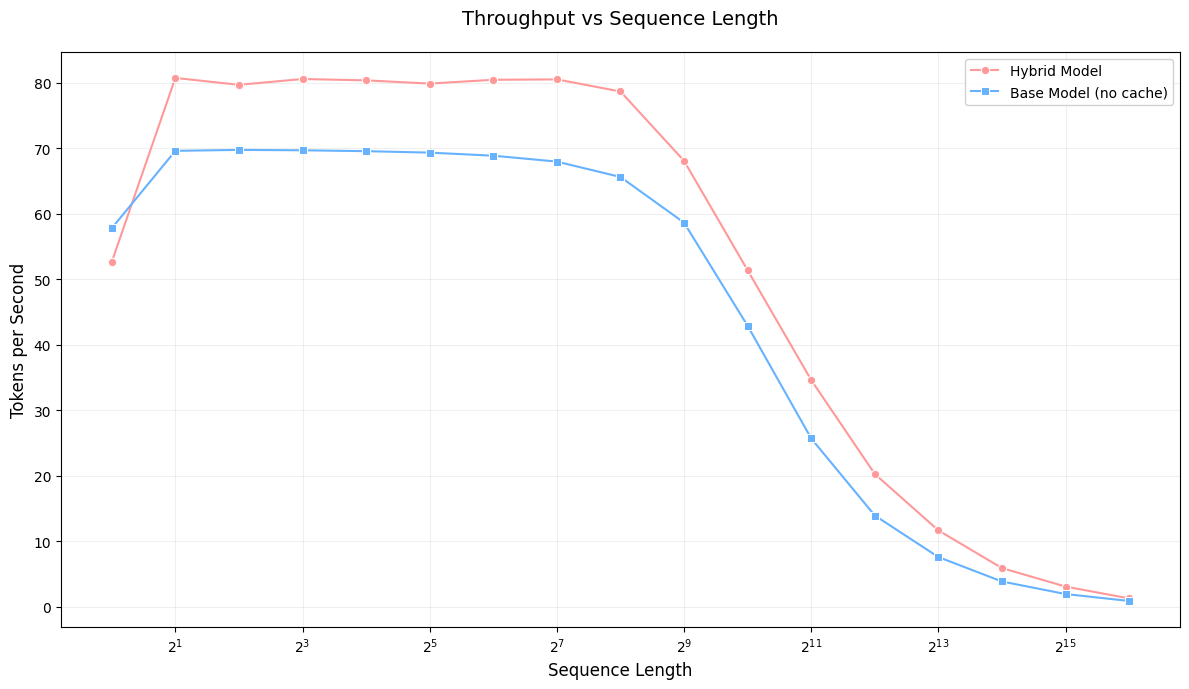

In [45]:
results_df = pd.DataFrame(results)
results_df.to_csv('throughput_results.csv', index=False)

create_stylized_plot(
    results_df,
    'tokens_per_sec',
    'Tokens per Second',
    'Throughput vs Sequence Length',
    'throughput_comparison_enhanced.png'
)

## Measure Sec/token

In [46]:
def measure_time_per_token(model, input_ids, use_cache=False, num_runs=3, new_tokens=20):
    """Measure seconds/token for generation (only counting generated tokens)"""
    torch.cuda.synchronize()
    start_times = []
    end_times = []
    
    # Warmup run
    _ = model.generate(input_ids, max_new_tokens=new_tokens, use_cache=use_cache)
    
    # Actual timing runs
    for _ in range(num_runs):
        torch.cuda.synchronize()
        start = time.perf_counter()
        
        _ = model.generate(input_ids, max_new_tokens=new_tokens, use_cache=use_cache)
        
        torch.cuda.synchronize()
        end = time.perf_counter()
        
        start_times.append(start)
        end_times.append(end)
    
    # Calculate seconds per token
    total_generated_tokens = new_tokens * num_runs
    total_time = sum([end - start for end, start in zip(end_times, start_times)])
    return total_time / total_generated_tokens

In [47]:
seq_lengths = [2**i for i in range(17)]  # 2^0 to 2^15
results = {
    'seq_length': [],
    'hybrid_sec_per_token': [],
    'base_no_cache_sec_per_token': []
}

In [48]:
print("\nRunning benchmarks...")
for seq_len in tqdm(seq_lengths):
    input_text = "A" * seq_len
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    
    if input_ids.shape[1] > Base_model.config.max_position_embeddings:
        break
        
    with torch.no_grad():
        hybrid_time = measure_time_per_token(hybrid_model, input_ids, use_cache=False)
        base_no_cache_time = measure_time_per_token(Base_model, input_ids, use_cache=False)
        # base_with_cache_time = measure_time_per_token(base_model, input_ids, use_cache=True)
    
    results['seq_length'].append(seq_len)
    results['hybrid_sec_per_token'].append(hybrid_time)
    results['base_no_cache_sec_per_token'].append(base_no_cache_time)
    # results['base_with_cache_sec_per_token'].append(base_with_cache_time)
    
    print(f"\nSequence length: {seq_len}")
    print(f"Hybrid model: {hybrid_time*1000:.2f} ms/token")
    print(f"Base model (no cache): {base_no_cache_time*1000:.2f} ms/token")
    # print(f"Base model (with cache): {base_with_cache_time*1000:.2f} ms/token")


Running benchmarks...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 1
Hybrid model: 18.72 ms/token
Base model (no cache): 20.61 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 2
Hybrid model: 12.37 ms/token
Base model (no cache): 14.38 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 4
Hybrid model: 12.39 ms/token
Base model (no cache): 14.30 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 8
Hybrid model: 12.35 ms/token
Base model (no cache): 14.28 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 16
Hybrid model: 12.40 ms/token
Base model (no cache): 14.32 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 32
Hybrid model: 12.41 ms/token
Base model (no cache): 14.35 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 64
Hybrid model: 12.44 ms/token
Base model (no cache): 14.45 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 128
Hybrid model: 12.56 ms/token
Base model (no cache): 14.62 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 256
Hybrid model: 12.70 ms/token
Base model (no cache): 15.06 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 512
Hybrid model: 14.73 ms/token
Base model (no cache): 16.67 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 1024
Hybrid model: 19.58 ms/token
Base model (no cache): 23.37 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 2048
Hybrid model: 28.92 ms/token
Base model (no cache): 38.99 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 4096
Hybrid model: 49.65 ms/token
Base model (no cache): 71.89 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 8192
Hybrid model: 86.02 ms/token
Base model (no cache): 131.41 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 16384
Hybrid model: 166.77 ms/token
Base model (no cache): 255.03 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 32768
Hybrid model: 321.56 ms/token
Base model (no cache): 504.42 ms/token


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene


Sequence length: 65536
Hybrid model: 763.42 ms/token
Base model (no cache): 1087.79 ms/token


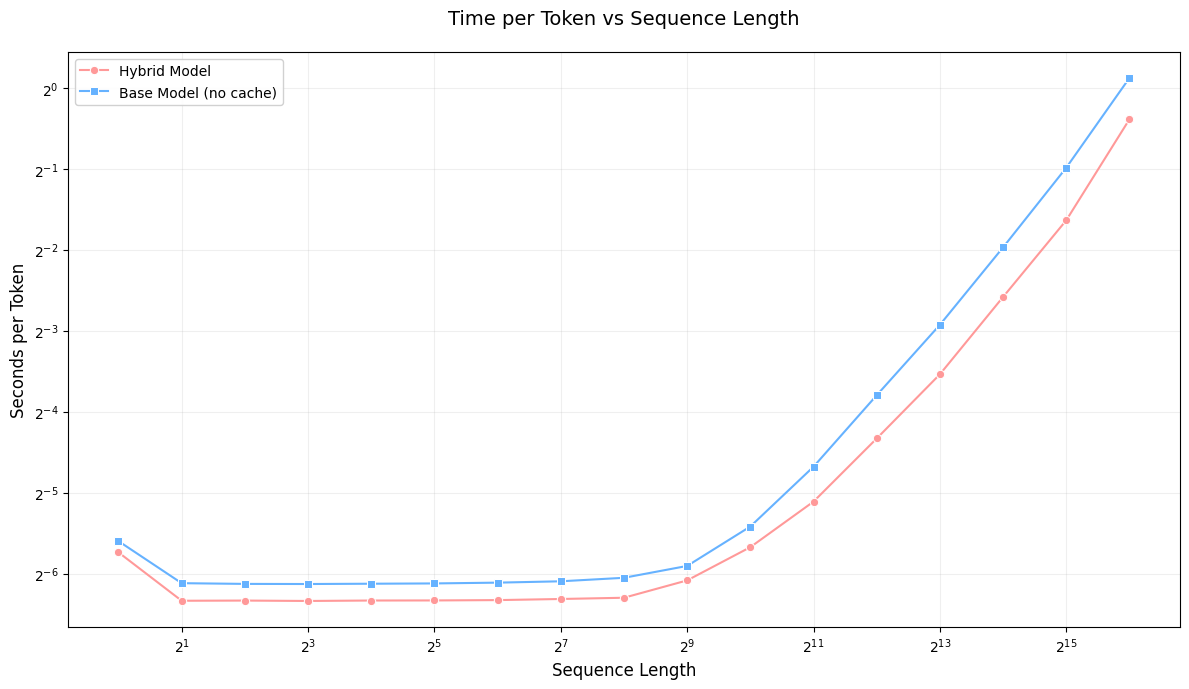

In [51]:
results_df = pd.DataFrame(results)
results_df.to_csv('time_per_token_results.csv', index=False)

create_stylized_plot(
    results_df,
    'sec_per_token',
    'Seconds per Token',
    'Time per Token vs Sequence Length',
    'time_per_token_comparison_enhanced.png'
)

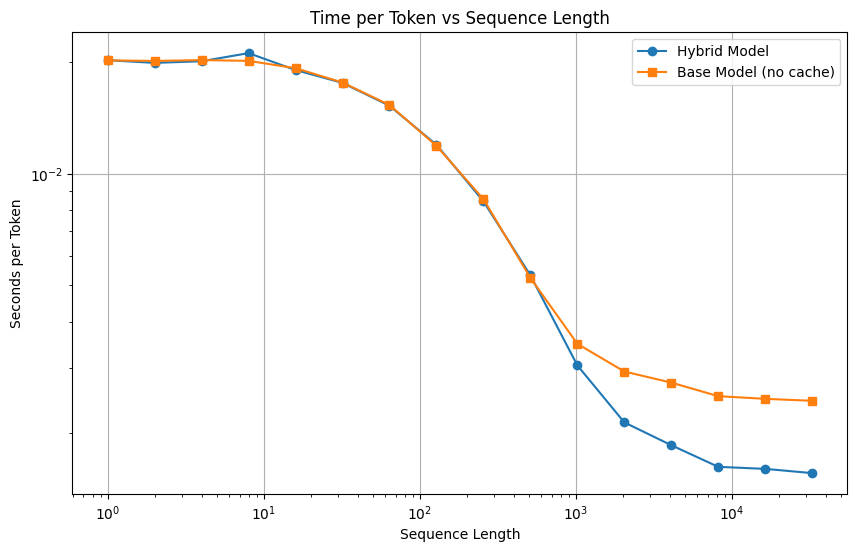

In [18]:
results_df = pd.DataFrame(results)
results_df.to_csv('time_per_token_results.csv', index=False)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results['seq_length'], results['hybrid_sec_per_token'], 
         label='Hybrid Model', marker='o')
plt.plot(results['seq_length'], results['base_no_cache_sec_per_token'], 
         label='Base Model (no cache)', marker='s')
# plt.plot(results['seq_length'], results['base_with_cache_sec_per_token'], 
#          label='Base Model (with cache)', marker='^')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sequence Length')
plt.ylabel('Seconds per Token')
plt.title('Time per Token vs Sequence Length')
plt.legend()
plt.grid(True)
plt.savefig('time_per_token_comparison.png')
#plt.close()